In [1]:
import os, sys
import numpy as np
from numpy.random import multinomial
import process_relion
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import itertools
import random, math
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import time

# Loading Data

In [2]:
#GPU or CPU
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev) 

In [18]:
#data path
file_path='F:/script/class2vec/real_star_file/10340_Reja_320_E10.star'
datatype=0 #0 is relion 3.1, 1 is relion 3, 2 is cryosparc

file_name=os.path.basename(file_path)
output_path=os.path.dirname(file_path)+'/'+os.path.splitext(file_name)[0]
if os.path.isdir(output_path) is False:
    os.mkdir(output_path)

In [19]:
# parameters
#window size
w = 1

#ignore classes
#ignore_classes=[3,13,15,44,23,7,22,26,14,28,18,38,47,48,11,35,37]
#ignore_classes=[1,2,3,5,8,10,14,15,17,18,19,21,22,23,24,27,28,31,32,33,34,35,37,38,40,41,44] #GSS20173_300
#ignore_classes=[1,6,7,8,16,17,19,20,21,24,36,38,46] 
#ignore_classes=[14] #10243_tau
#ignore_classes=[2,3,4,11,12,19,20,25,33,36,37,40,43,44,45,46,47,48,49,50] #10340_Case2_tau_ig
ignore_classes=[]

#embedding size
#embedding_size=100

#


In [20]:
if datatype<2:
    file_info=process_relion.read_relion(file_path)
    if datatype==0:
        #read data (relion3.1)
        dataset=file_info.getRdata_31()
        optics=file_info.extractoptic()
    else:
        #read relion 3.0
        dataset=file_info.getRdata()
    metadata=dataset[0]
    print(metadata)
    data=dataset[1]
    print(data[0])
    corpus_information=process_relion.process_helical(dataset).extarct_helical()
else:
    #read cryosparc
    dataset=np.load(file_path)
    corpus_information=process_relion.process_cryosparc_helical(dataset).extract_helical()
corpus_dic=corpus_information[0]
corpus=list(corpus_dic.values())
corpus_backup=corpus[:]

['_rlnCoordinateX', '_rlnCoordinateY', '_rlnHelicalTubeID', '_rlnAngleTiltPrior', '_rlnAnglePsiPrior', '_rlnHelicalTrackLengthAngst', '_rlnAnglePsiFlipRatio', '_rlnAngleRotFlipRatio', '_rlnImageName', '_rlnMicrographName', '_rlnOpticsGroup', '_rlnCtfMaxResolution', '_rlnCtfFigureOfMerit', '_rlnDefocusU', '_rlnDefocusV', '_rlnDefocusAngle', '_rlnCtfBfactor', '_rlnCtfScalefactor', '_rlnPhaseShift', '_rlnGroupNumber', '_rlnAngleRot', '_rlnAngleTilt', '_rlnAnglePsi', '_rlnOriginXAngst', '_rlnOriginYAngst', '_rlnClassNumber', '_rlnNormCorrection', '_rlnLogLikeliContribution', '_rlnMaxValueProbDistribution', '_rlnNrOfSignificantSamples']
['1365.689787', '169.791979', '1', '90.000000', '-53.25944', '164.499993', '0.500000', '0.500000', '000001@Extract/job040/Micrographs/FoilHole_21756216_Data_21768957_21768958_20181221_2054-115048.mrcs', 'Micrographs/FoilHole_21756216_Data_21768957_21768958_20181221_2054-115048.mrc', '1', '4.124138', '0.074823', '19105.767578', '17957.419922', '14.688353', '0

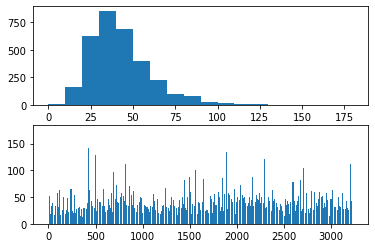

In [21]:
corpus_length_histogram=[]
for i in range(len(corpus_backup)):
    corpus_length_histogram.append(len(corpus_backup[i]))
fig,ax=plt.subplots(2)
ax[0].hist(corpus_length_histogram,list(range(0,max(corpus_length_histogram)+10,10)))
ax[1].bar(list(range(0,len(corpus_backup))),corpus_length_histogram)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"length_histogram.png",bbox_inches='tight', pad_inches=0.01)

# Pre-processing

In [22]:
#k-mer seperation
def overlaping_kmer(data,k):
    kmer_corpus=[]
    for i in range(len(data)):
        lst=data[i]
        kmer_lst=[]
        for j in range(len(lst)-k+1):
            kmer_lst.append(str(lst[j])+'-'+str(lst[j+1]))
        kmer_corpus.append(kmer_lst)
    return kmer_corpus

In [23]:
def cut_corpus(corpus,cut_length):
    new_corpus=[]
    cut_length=cut_length
    print(len(corpus))
    for i in range(len(corpus)):
        lst=corpus[i]
        n=len(lst)
        if n<cut_length:
            new_corpus.append(lst)
            continue
        cut_amount=int((n-n%cut_length)/cut_length)
        for j in range(cut_amount-1):
            new_corpus.append(lst[j*cut_length:(j+1)*cut_length])
        new_corpus.append(lst[(cut_amount-1)*cut_length:])
    print(len(new_corpus))
    return new_corpus

In [24]:
#corpus=overlaping_kmer(corpus_backup,2)
#corpus_context=corpus[:]

In [25]:
vocabulary = set(itertools.chain.from_iterable(corpus))
vocabulary_size = len(vocabulary)
print(vocabulary_size)

10


In [26]:
word_to_index = {w: idx for (idx, w) in enumerate(vocabulary)}
index_to_word = {idx: w for (idx, w) in enumerate(vocabulary)}

In [27]:
#corpus=cut_corpus(corpus_backup,60)
corpus_context=corpus_backup[:]

In [28]:
def sample_negative(sample_size):
    sample_probability = {}
    word_counts = dict(Counter(list(itertools.chain.from_iterable(corpus))))
    normalizing = sum([v**0.75 for v in word_counts.values()])
    for word in word_counts:
        sample_probability[word] = word_counts[word]**0.75 / normalizing
    words = np.array(list(word_counts.keys()))
    while True:
        word_list = []
        sampled_index = np.array(multinomial(sample_size, list(sample_probability.values())))
        for index, count in enumerate(sampled_index):
            for _ in range(count):
                 word_list.append(words[index])
        yield word_list

In [29]:
# convert to windoes vector

context_tuple_list = []
negative_samples = sample_negative(4)

for text in corpus_context:
    for i, word in enumerate(text):
        #if int(word) in ignore_classes:
        #    continue
        first_context_word_index = max(0,i-w)
        last_context_word_index = min(i+w, len(text))
        for j in range(first_context_word_index, last_context_word_index):
            #if int(text[j]) in ignore_classes:
            #    continue
            if i!=j:
                context_tuple_list.append((word, text[j], next(negative_samples)))
print("There are {} pairs of target and context words".format(len(context_tuple_list)))

There are 134652 pairs of target and context words


# Word2vec

In [30]:
def get_batches(context_tuple_list, batch_size=100):
    random.shuffle(context_tuple_list)
    batches = []
    batch_target, batch_context, batch_negative = [], [], []
    for i in range(len(context_tuple_list)):
        batch_target.append(word_to_index[context_tuple_list[i][0]])
        batch_context.append(word_to_index[context_tuple_list[i][1]])
        batch_negative.append([word_to_index[w] for w in context_tuple_list[i][2]])
        if (i+1) % batch_size == 0 or i == len(context_tuple_list)-1:
            tensor_target = torch.from_numpy(np.array(batch_target)).long().to(device)
            tensor_context = torch.from_numpy(np.array(batch_context)).long().to(device)
            tensor_negative = torch.from_numpy(np.array(batch_negative)).long().to(device)
            batches.append((tensor_target, tensor_context, tensor_negative))
            batch_target, batch_context, batch_negative = [], [], []
    return batches

In [31]:
class Word2Vec(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.target = nn.Embedding(vocab_size, embedding_size).cuda()
        self.context = nn.Embedding(vocab_size, embedding_size).cuda()

    def forward(self, target_word, context_word, negative_example):
        emb_target = self.target(target_word)
        emb_context = self.context(context_word)
        emb_product = torch.mul(emb_target, emb_context).cuda()
        emb_product = torch.sum(emb_product, dim=1).cuda()
        out = torch.sum(F.logsigmoid(emb_product)).cuda()
        emb_negative = self.context(negative_example)
        emb_product = torch.bmm(emb_negative, emb_target.unsqueeze(2)).cuda()
        emb_product = torch.sum(emb_product, dim=1).cuda()
        out += torch.sum(F.logsigmoid(-emb_product)).cuda()
        return -out

In [32]:
class EarlyStopping():
    def __init__(self, patience=5, min_percent_gain=0.1):
        self.patience = patience
        self.loss_list = []
        self.min_gain = min_percent_gain / 100.
        
    def update_loss(self, loss):
        self.loss_list.append(loss)
        if len(self.loss_list) > self.patience:
            del self.loss_list[0]
    
    def stop(self):
        if len(self.loss_list) == 1:
            return False
        gain = (max(self.loss_list) - min(self.loss_list)) / max(self.loss_list)
        print("Loss gain: {}%".format(gain*100))
        if gain < self.min_gain:
            return True
        else:
            return False
        

In [33]:
embedding_size=100
loss_function = nn.CrossEntropyLoss()
net = Word2Vec(embedding_size=embedding_size, vocab_size=vocabulary_size)
optimizer = optim.Adam(net.parameters())
early_stopping = EarlyStopping(patience=5, min_percent_gain=1)

while True:
    losses = []
    context_tuple_batches = get_batches(context_tuple_list, batch_size=100)
    for i in range(len(context_tuple_batches)):
        net.zero_grad()
        target_tensor, context_tensor, negative_tensor = context_tuple_batches[i]
        loss = net(target_tensor, context_tensor, negative_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    print("Loss: ", torch.mean(torch.stack(losses)),torch.stack(losses)[0],torch.stack(losses)[-1])
    early_stopping.update_loss(torch.mean(torch.stack(losses)))
    if early_stopping.stop() is True:
        break
    if torch.mean(torch.stack(losses))<10:
        break

Loss:  tensor(206.0077, device='cuda:0') tensor(1117.4270, device='cuda:0') tensor(54.4126, device='cuda:0')
Loss:  tensor(99.6998, device='cuda:0') tensor(93.9788, device='cuda:0') tensor(51.1686, device='cuda:0')
Loss gain: 51.60383605957031%
Loss:  tensor(99.5729, device='cuda:0') tensor(97.3113, device='cuda:0') tensor(53.1077, device='cuda:0')
Loss gain: 51.665435791015625%
Loss:  tensor(99.4777, device='cuda:0') tensor(105.4084, device='cuda:0') tensor(54.1616, device='cuda:0')
Loss gain: 51.711666107177734%
Loss:  tensor(99.4808, device='cuda:0') tensor(99.8171, device='cuda:0') tensor(51.7570, device='cuda:0')
Loss gain: 51.711666107177734%
Loss:  tensor(99.4621, device='cuda:0') tensor(101.5611, device='cuda:0') tensor(51.1427, device='cuda:0')
Loss gain: 0.2384093999862671%


# Show 2D class embedding

In [34]:
import umap
import sklearn
from sklearn.cluster import KMeans,SpectralClustering,MeanShift, estimate_bandwidth,AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA

import matplotlib.patches as mpatches

EMBEDDINGS.shape:  (10, 100)
1
2
3
4
5
6
7
8


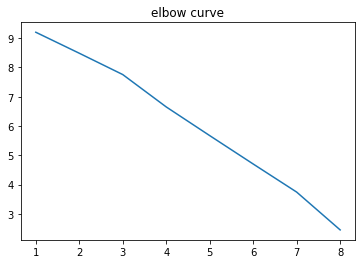

In [57]:
EMBEDDINGS = net.target.weight.data.cpu().numpy()
print('EMBEDDINGS.shape: ', EMBEDDINGS.shape)

res = []
n_cluster = range(1,9)
for n in n_cluster:
    print(n)
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(EMBEDDINGS)
    res.append(np.average(np.min(cdist(EMBEDDINGS, kmeans.cluster_centers_, 'euclidean'), axis=1)))
        
plt.plot(n_cluster, res)
plt.title('elbow curve')
plt.show()

D:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:1679: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


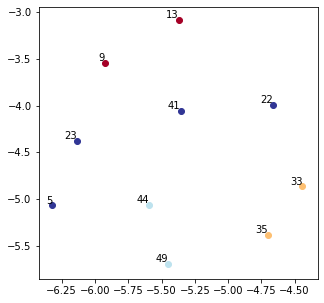

In [58]:
# see the 2D class segments embedding
class_umap=umap.UMAP(n_neighbors=50,min_dist=0,n_components=2).fit_transform(EMBEDDINGS)
cluster_number=6
kmeans_best = SpectralClustering(n_clusters=cluster_number).fit_predict(class_umap)
EMBEDDINGS_np=np.array(EMBEDDINGS)
plt.figure(figsize = (5,5))
for i in range(vocabulary_size):
    # print('vocab_idx: ', vocab_idx)
    plt.scatter(class_umap[i][0], class_umap[i][1],color=plt.cm.RdYlBu(kmeans_best[i]/3))
    plt.annotate(index_to_word[i], xy = (class_umap[i][0], class_umap[i][1]), \
        ha='right',va='bottom')
plt.savefig(output_path+'/'+'w2v.png')
plt.show()

In [59]:

#word_to_cluster={}
#for i in range(cluster_number):
#    word_to_cluster[str(i)]= np.array(np.where(kmeans_best==i)).ravel()+1
#print(word_to_cluster)

##using the histogram method to cluster 



#cluster_corpus=corpus[:]
#for i in range(cluster_number):
#    cluster_lst=list(word_to_cluster[str(i)])
#    for j in range(len(cluster_corpus)):
#        filament=cluster_corpus[j]
#        filament=[i if np.int64(x) in cluster_lst else x for x in filament]
#        cluster_corpus[j]=filament

#filament_cluster_percentage=[]
#for filament in cluster_corpus:
#    filament_lenghth=len(filament)
#    pert=[]
#    for i in range(cluster_number):
#        cluster_per=float(filament.count(i))/filament_lenghth
#        pert.append(cluster_per)
#    filament_cluster_percentage.append(pert)

#histogram clustering
#pca_filaments = PCA(n_components=2).fit_transform(filament_cluster_percentage)
#plt.figure(figsize = (5, 5))
#for i in range(len(cluster_corpus)):
#    plt.scatter(pca_filaments[i][0], pca_filaments[i][1],color='blue')
#plt.savefig("cluster.png")
#plt.show()

# Show Filament Embedding and cluster

In [60]:
# average filament embedding

filament_cluster_number=2
filament_score=[]
all_data=[]
for filament in corpus:
    score=torch.zeros(embedding_size)
    counts=0
    for i in filament:
        #if int(i) in ignore_classes:
        #    continue
        counts+=1
        score=score+EMBEDDINGS[word_to_index[i]]
    if counts==0:
        if filament_score==[]:
            filament_score.append(np.zeros(100))
            continue
        else:
            filament_score.append(filament_score[-1])
            continue
    score=score/counts
    filament_score.append(np.array(score))
all_data=filament_score[:]
all_data.extend(EMBEDDINGS_np)
filament_number=len(filament_score)
print(filament_number)

3233


In [219]:
# average filament embedding

filament_cluster_number=2
filament_score=[]
all_data=[]
for filament in corpus:
    score=torch.zeros(embedding_size)
    counts=0
    filament_list=[]
    for i in filament:
        #if int(i) in ignore_classes:
        #    continue
        counts+=1
        filament_list.append(EMBEDDINGS[word_to_index[i]])
    if counts==0:
        if filament_score==[]:
            filament_score.append(np.zeros(100))
            continue
        else:
            filament_score.append(filament_score[-1])
            continue
    print(type(filament_list[0]))
    filament_list=np.array(filament_list).T
    dim=len(filament_list[:,0])
    mean=filament_list.mean(axis=1).reshape((dim,1))
    var=np.zeros((dim,dim),dtype=float)
    for i in range(filament_list.shape[1]):
        vector=filament_list[:,i]-mean
        var+=np.dot(vector,vector.T)
    variance_inv=np.linalg.inv(var)
    variance_det=np.linalg.det(var)
    scalar=np.sqrt(np.pi**dim*variance_det)
    filament_normalized=np.exp(-0.5*((filament_list-mean).T @ variance_inv @ (filament_list-mean))).diagonal()/scalar
    score=np.multiply(filament_list, filament_normalized).mean(axis=1)
    print(score)
    filament_score.append(np.array(score))
all_data=filament_score[:]
all_data.extend(EMBEDDINGS_np)
filament_number=len(filament_score)
print(filament_number)

<class 'numpy.ndarray'>


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp
D:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


[ nan  inf  nan  nan  inf -inf  nan  nan -inf  nan -inf  nan  inf  nan
 -inf  nan  nan  nan  nan  nan  nan -inf -inf  inf  nan  nan  nan  nan
  nan  nan -inf  nan  nan  nan  inf  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  inf  nan  nan  nan  nan  nan  nan  nan  inf  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan -inf  nan  nan  nan  nan  nan  nan  nan  nan
 -inf  nan]
<class 'numpy.ndarray'>


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[-inf  nan -inf  nan  nan -inf -inf  inf  nan  nan  nan  nan  nan -inf
  nan  nan  inf  inf -inf  nan  nan  nan  nan  inf  inf -inf  inf -inf
  inf  inf  nan  inf  nan -inf  inf  nan  nan  nan  nan  inf  inf  nan
  nan  nan -inf  nan -inf  nan  nan  nan  nan  inf  nan  inf  nan  nan
  nan  nan  inf  nan -inf  inf -inf  inf  nan  inf  inf  nan  nan  inf
  nan -inf  nan  inf  nan  nan  nan  nan -inf  inf  nan  nan  inf -inf
  nan  nan  nan  inf  nan -inf  nan  nan  nan -inf  inf  nan  inf  nan
  nan  nan]
<class 'numpy.ndarray'>
[-inf  inf  nan -inf  inf  nan  nan 

 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[-inf  inf -inf -inf  inf -inf -inf  inf -inf -inf -inf -inf  inf -inf
 -inf  inf  inf  inf -inf -inf  inf -inf -inf  inf  inf -inf  inf -inf
  inf  inf -inf  inf -inf -inf  inf  inf -inf -inf -inf  inf  inf  inf
  inf -inf -inf -inf -inf  inf -inf  inf  inf  inf -inf  inf -inf  inf
 -inf  inf  inf  inf -inf  inf -inf  inf  inf  inf  inf  inf  inf  inf
  inf -inf  inf  inf  inf -inf  inf  inf -inf  inf  inf  inf  inf -inf
 -inf  inf -inf  inf  inf -inf -inf -inf  inf -inf  inf -inf  inf -inf
 -inf 

 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[ inf  inf -inf  inf  inf  inf  inf  inf  inf -inf -inf -inf  inf -inf
 -inf -inf -inf  inf  inf  inf -inf  inf  inf -inf  inf  inf  inf -inf
  inf -inf  inf -inf  inf  inf  inf  inf  inf  inf -inf -inf  inf  inf
  inf -inf  inf -inf  inf  inf  inf -inf -inf -inf -inf -inf  inf  inf
 -inf -inf  inf  inf  inf  inf  inf -inf -inf  inf  inf -inf  inf -inf
 -inf -inf -inf -inf -inf -inf  inf -inf  inf  inf  inf -inf -inf -inf
 -inf  inf  inf  inf  inf -inf -inf  inf  inf -inf -inf -inf  inf -inf
  inf -inf]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan

 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan 

 -inf  inf]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
<class 'numpy.ndarray'>
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan -inf  nan  nan  nan  nan  inf  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan -inf  nan 

  nan  nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan 

 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[ nan  inf  nan  nan  inf  inf  nan  nan  nan -inf -inf  nan  nan -inf
  nan  nan -inf  nan  nan  inf -inf  inf  nan -inf  nan  inf  nan -inf
  nan -inf  inf -inf  inf  nan  nan  inf  nan  inf -inf  nan  inf  inf
  inf -inf  nan -inf  nan  nan  inf  nan -inf  nan -inf -inf  inf  inf
  nan -inf  inf  nan  nan  nan  inf -inf -inf  nan  nan  nan  inf -inf
  nan  nan  nan  nan -inf  nan  nan -inf  inf  inf  inf  nan  nan -inf
  nan  inf  inf  inf  inf  nan -inf  nan  inf -inf  nan  nan  nan -inf
  nan  nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in true_divide


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan inf nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan -inf  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  inf  nan  nan  inf  nan
  nan  nan  nan  nan  nan  nan  nan  nan -inf  nan  nan  nan  inf  nan
  nan  nan  inf  nan  nan  nan  nan  nan -inf  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan -inf  nan  nan  nan  nan  nan  nan
  nan  nan  inf  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan

 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan

  4.66771425e+184 -1.45420919e+184 -1.61554571e+184 -7.47798311e+184]
<class 'numpy.ndarray'>
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan -inf
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  n

  4.14303170e+41 -1.29074628e+41 -1.43394748e+41 -6.63740739e+41]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[-inf  inf  inf -inf  inf -inf  inf -inf -inf  inf -inf  inf  inf  inf
 -inf -inf  inf -inf  inf -inf -inf -inf -inf  inf -inf  inf -inf  inf
 -inf -inf -inf  inf -inf -inf  inf -inf  inf  inf -inf -inf  inf -inf
 -inf  inf  inf  inf  inf -inf -inf  inf -inf  inf -inf  inf  inf -inf
  inf  inf  inf -inf  inf -inf -inf -inf -inf  inf  inf -inf -inf  inf
 -inf  inf -inf  inf  inf  inf -inf -inf -inf -inf -inf  inf -inf  inf
  inf -inf  inf -inf -inf -inf -inf -inf -inf  inf  i

  nan  nan]
<class 'numpy.ndarray'>
[ nan  inf  inf  nan  inf  nan  nan  nan -inf  nan -inf  nan  nan  nan
  nan  nan  nan  nan  nan  nan -inf  nan -inf  nan  nan  nan  nan  nan
 -inf  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan -inf  nan  nan  nan  nan  nan  nan  inf  nan
  inf  nan  nan -inf  nan  nan  nan -inf -inf  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  inf  nan  inf  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
 -inf  nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>


 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[ nan  nan  nan  nan  nan -inf  nan  nan -inf  nan  nan  nan  inf  nan
  nan  nan  nan  nan  nan -inf  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan -inf  nan  nan -inf  inf  nan  nan  nan -inf  nan  nan  nan
  nan  nan  nan  nan  nan  nan -inf  inf  nan  inf -inf  inf  nan  nan
  nan  inf  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  inf
  nan  nan  nan  inf  inf  nan  nan  nan -inf  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan -inf  nan -inf  nan  nan  nan  nan  inf  nan
  nan  nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan

 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[ nan  inf  nan  nan  inf  nan  nan  nan  nan -inf -inf  nan  nan -inf
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan -inf
  nan  nan  nan  nan  nan  nan  nan  inf  nan  nan -inf  nan  inf  inf
  inf -inf  nan -inf  nan  nan  nan  nan  nan  nan -inf  nan  nan  inf
  nan  nan  inf  nan  nan  nan  nan  nan  nan  nan  nan  nan  inf  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  inf  inf  nan  nan -inf
  nan  inf  nan  inf  inf  nan -inf  nan  inf -inf  nan  nan  nan -inf
  nan  nan]
<class 'numpy.ndarray'>
[ nan  nan  nan  nan  nan -inf  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan -inf  nan  nan  inf  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  inf -inf  inf  nan  nan  nan  nan -inf
 -inf  nan  nan  inf  nan -inf  nan  nan  nan  nan  nan  nan  inf -inf
  inf  nan  nan -inf  nan  nan  nan  nan -inf  inf  nan -inf  nan  nan
 -inf  nan -inf  nan  nan  nan  nan  nan  nan 

 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[-inf  inf  inf -inf  inf  inf -inf -inf -inf -inf -inf  inf -inf -inf
  inf  inf -inf -inf -inf  inf -inf  inf -inf -inf -inf  inf -inf -inf
 -inf -inf  inf -inf  inf -inf -inf  inf -inf  inf -inf  inf  inf  inf
  inf -inf -inf -inf -inf -inf  inf  inf -inf  inf -inf -inf  inf  inf
  inf -inf  inf -inf -inf -inf  inf -inf -inf -inf -inf  inf  inf -inf
  inf  inf  inf  inf -inf  inf -inf -inf  inf  inf  inf  inf  inf -inf
  inf  inf  inf  inf  inf  inf -inf -inf  inf -inf  inf  inf -inf -inf
 -inf 

 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[ nan  nan  nan  nan  nan -inf  nan  nan  nan  nan  nan  inf  nan  nan
 

 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan

 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan

  inf -inf]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan 

  nan  nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan 

  nan  nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[ nan  inf  nan  nan  inf  nan  nan  nan  nan  nan -inf  nan  inf  nan
 -inf  nan  nan  nan  nan  nan 

<class 'numpy.ndarray'>
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan -inf  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan -inf  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan]
<class 'numpy.ndarray'>
[-inf  inf -inf -inf  inf -inf -inf  inf -inf -inf -inf -inf  inf -inf
 -inf  inf  inf  inf -inf -inf  inf -inf -inf  inf  inf -inf  inf -inf
  inf  inf -inf  inf -inf -inf  inf  inf -inf -inf -inf  inf  inf  inf
  inf -inf -inf -inf -inf  inf -inf  inf  inf  inf -inf  inf -inf  inf
 -inf  inf  inf  inf -inf  inf -inf  inf  inf  inf  inf  inf  inf  inf
  inf -inf  inf  inf  inf -inf  inf  inf -inf  inf  inf  inf  inf -inf
 -inf  inf -inf  

 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan

 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[ nan  nan -inf  nan  nan -inf -inf  inf -inf -inf  nan  nan  inf  nan
 

  nan  nan]
<class 'numpy.ndarray'>
[ inf  inf  inf  inf  inf -inf -inf  inf -inf -inf -inf -inf  inf -inf
 -inf  inf -inf  inf -inf  inf -inf -inf -inf  inf  inf -inf  inf  inf
 -inf  inf -inf -inf  inf  inf  inf -inf  inf -inf  inf  inf -inf -inf
 -inf -inf -inf  inf -inf -inf  inf -inf  inf -inf  inf -inf  inf -inf
  inf  inf -inf -inf -inf  inf  inf -inf -inf  inf -inf -inf  inf -inf
 -inf -inf -inf -inf -inf -inf  inf  inf  inf -inf  inf -inf  inf  inf
  inf -inf  inf  inf -inf -inf  inf  inf  inf  inf -inf -inf -inf  inf
 -inf  inf]
<class 'numpy.ndarray'>
[-inf  inf  inf -inf  inf  inf -inf -inf -inf -inf -inf  inf -inf -inf
  inf  inf -inf -inf -inf  inf -inf  inf -inf -inf -inf  inf -inf -inf
 -inf -inf  inf -inf  inf -inf -inf  inf -inf  inf -inf  inf  inf  inf
  inf -inf -inf -inf -inf -inf  inf  inf -inf  inf -inf -inf  inf  inf
  inf -inf  inf -inf -inf -inf  inf -inf -inf -inf -inf  inf  inf -inf
  inf  inf  inf  inf -inf  inf -inf -inf  inf  inf  inf  inf  inf -inf
  inf

 -inf  inf]
<class 'numpy.ndarray'>
[ inf  inf  nan  inf  inf  nan  nan  inf  nan -inf -inf -inf  inf -inf
 -inf  nan -inf  inf  nan  inf -inf  nan  nan  nan  inf  nan  inf  nan
  nan  nan  nan -inf  inf  inf  inf  nan  inf  nan  nan  nan  nan  nan
  nan -inf  nan  nan  nan  nan  inf -inf  nan -inf  nan -inf  inf  nan
  nan  nan  nan  nan  nan  inf  inf -inf -inf  inf  nan -inf  inf -inf
 -inf -inf -inf -inf -inf -inf  inf  nan  inf  nan  inf -inf  nan  nan
  nan  nan  inf  inf  nan -inf  nan  inf  inf  nan -inf -inf  nan  nan
  nan  nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>


 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[ nan  inf  nan  nan  inf  nan  nan  nan  nan  nan -inf  nan  nan  nan
  nan  nan  nan  nan  nan  nan -inf  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  inf  nan
  nan  nan  nan  nan  nan  nan  nan -inf -inf  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  inf  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan

 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[-inf  inf  inf -inf  inf  inf -inf -inf -inf -inf -inf  inf -inf -inf
  inf  inf -inf -inf -inf  inf -inf  inf -inf -inf -inf  inf -inf -inf
 -inf -inf  inf -inf  inf -inf -inf  inf -inf  inf -inf  inf  inf  inf
  inf -inf -inf -inf -inf -inf  inf  inf -inf  inf -inf -inf  inf  inf
  inf -inf  inf -inf -inf -inf  inf -inf -inf -inf -inf  inf  inf -inf
  inf  inf  inf  inf -inf  inf -inf -inf  inf  inf  inf  inf  inf -inf
  inf  inf  inf  inf  inf  inf -inf -inf  inf -inf  inf  inf -inf -inf
 -inf  inf]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan

  nan  nan]
<class 'numpy.ndarray'>
[-inf  nan  nan  nan  nan  nan -inf  nan  nan  nan  nan  nan  nan -inf
  nan  nan  nan  nan -inf  nan  nan  nan  nan  nan  nan  nan  nan -inf
  nan  nan  nan  nan  nan -inf  nan  nan  nan  nan  nan  inf  inf  nan
  nan  nan -inf  nan -inf  nan  nan  nan  nan  inf  nan  nan  nan  nan
  nan  nan  inf  nan -inf  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  inf  nan  nan  nan  nan  nan  inf  nan  nan  inf -inf
  nan  nan  nan  inf  nan  nan  nan  nan  nan -inf  inf  nan  nan  nan
  nan  nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>


  8.77434149e+07 -8.30823245e+07  6.89637298e+07 -8.56549280e+07]
<class 'numpy.ndarray'>
[-inf  inf -inf -inf  inf -inf -inf  inf -inf -inf -inf -inf  inf -inf
 -inf  inf  inf  inf -inf -inf  inf -inf -inf  inf  inf -inf  inf -inf
  inf  inf -inf  inf -inf -inf  inf  inf -inf -inf -inf  inf  inf  inf
  inf -inf -inf -inf -inf  inf -inf  inf  inf  inf -inf  inf -inf  inf
 -inf  inf  inf  inf -inf  inf -inf  inf  inf  inf  inf  inf  inf  inf
  inf -inf  inf  inf  inf -inf  inf  inf -inf  inf  inf  inf  inf -inf
 -inf  inf -inf  inf  inf -inf -inf -inf  inf -inf  inf -inf  inf -inf
 -inf  inf]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan

 -inf  nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan 

 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan -inf  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan -inf  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan 

  3.33333663e-34  1.63502368e-33  1.59743918e-33  1.18718054e-33]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan

  2.48816619e+147 -4.61895257e+146 -4.87027792e+147  8.01597015e+146]
<class 'numpy.ndarray'>
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
<class 'numpy.ndarray'>
[-inf  inf  nan -inf  inf  nan  nan  nan -inf  nan -inf  nan  nan  nan
  nan  nan  nan  nan  nan  nan  nan  nan -inf  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan -inf  nan  nan  nan  nan -inf  nan  inf  nan
  nan  nan  nan  nan  nan  nan  nan  inf  nan  inf -inf  nan  nan  nan
  nan  nan  inf  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  inf  nan  nan  nan  nan  nan  nan  nan  inf  nan  nan
  nan  nan  nan  nan  nan  nan -inf -inf  nan  na

KeyboardInterrupt: 

In [236]:
a=np.random.random_sample((100,5)).T
dim=len(a[:,0])
mean=a.mean(axis=1).reshape((dim,1))
var=np.zeros((dim,dim),dtype=float)
for i in range(a.shape[1]):
    vector=a[:,i]-mean
    var+=np.dot(vector,vector.T)
variance=np.cov(a)
print(variance-var/(dim-1))
variance_inv=np.linalg.inv(var)
variance_det=np.linalg.det(var)
scalar=np.sqrt(np.pi**dim*variance_det)
c=np.exp(-0.5*((a-mean).T @ variance_inv @ (a-mean))).diagonal()
print(c)
print(np.multiply(a,c).mean(axis=1))

[[-11.09580629 -10.56770715 -10.66686966 -10.53138578 -10.50437779]
 [-10.56770715 -10.63187742 -10.68996895 -10.7478378  -10.75623783]
 [-10.66686966 -10.68996895 -10.60527213 -10.6856191  -10.69766735]
 [-10.53138578 -10.7478378  -10.6856191  -10.65113443 -10.75668985]
 [-10.50437779 -10.75623783 -10.69766735 -10.75668985 -10.68207176]]


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


[inf  0. inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf  0. inf inf  0. inf inf inf
  0. inf inf inf inf inf inf  0. inf inf  0. inf inf  0. inf inf  0. inf
  0. inf inf inf inf inf inf inf inf inf inf  0. inf inf inf inf inf inf
 inf inf inf inf inf inf inf inf inf inf inf inf  0. inf  0. inf inf inf
 inf inf inf inf  0. inf  0. inf inf  0.]
[inf inf inf inf inf]


In [244]:
from scipy.stats import multivariate_normal
mean=a.mean(axis=1)
y = multivariate_normal.pdf(a.T, mean=mean, cov=variance)
print(y)

[1.40171316 0.31368005 0.08558673 0.05579653 0.84466385 1.44599313
 0.2759393  0.62772339 0.11374376 0.09828142 0.52175711 0.20138672
 0.42099533 1.10325642 0.3056133  0.44059982 0.30197221 0.21005998
 0.10535293 2.84395095 1.58480155 2.4821429  0.84905213 1.16950005
 0.3199146  0.19525107 1.87040185 0.0397319  0.32657186 0.36879395
 2.30259118 0.44374746 0.45419472 0.12670496 0.83380012 0.34464085
 0.7893299  0.22576553 0.50313151 0.17786275 0.93717017 0.04576689
 2.25598211 0.07058555 0.91151771 0.91877745 0.39156105 0.07423937
 0.78486813 0.24035058 0.5393183  0.37991473 0.14410408 0.10191708
 0.06675507 0.5119214  0.53766902 0.24882258 0.17821102 0.21896777
 1.13353426 2.61999685 0.42066073 0.43303381 0.21000194 0.53458644
 1.69492532 0.46667228 0.88492742 0.97792455 0.44820779 0.46184421
 0.50440927 1.61141034 0.08372144 0.29556289 0.2736568  1.25559309
 1.19607027 1.22105931 0.95686843 0.20171112 2.32012754 0.78558754
 1.62843413 0.51848027 0.26976694 0.36225778 0.39951164 0.5285

In [108]:
x = [-2.1, -1,  4.3]
y = [3,  1.1,  0.12]
X = np.stack((x, y), axis=0)
print(X,np.shape(X))
np.cov(X)

[[-2.1  -1.    4.3 ]
 [ 3.    1.1   0.12]] (2, 3)


array([[11.71      , -4.286     ],
       [-4.286     ,  2.14413333]])

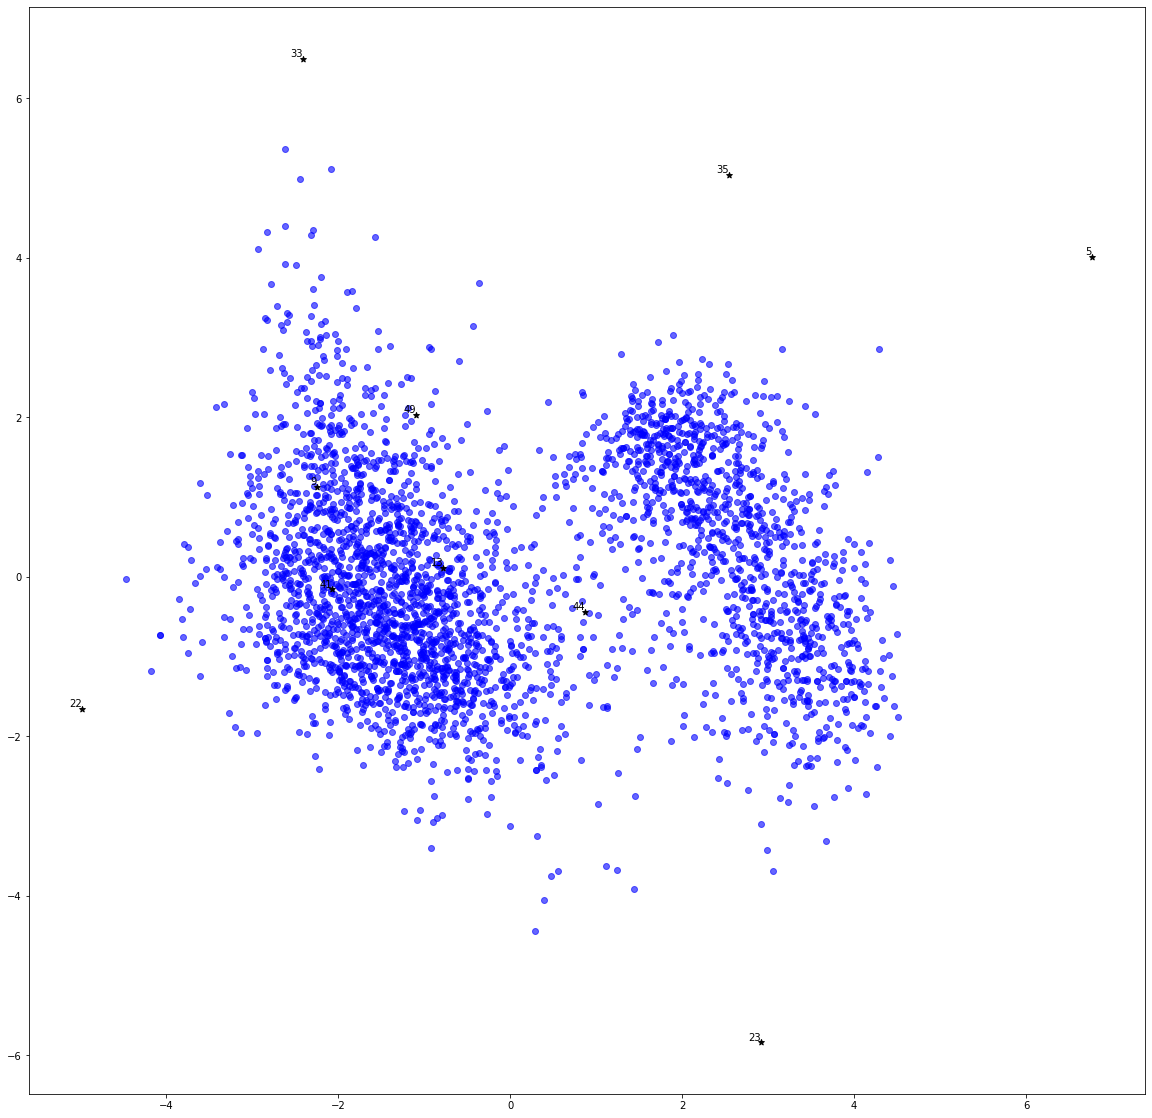

In [165]:
pca_sum = PCA(n_components=2).fit_transform(all_data)
pca_sum_3D = PCA(n_components=3).fit_transform(all_data)
#cluster_pca = KMeans(n_clusters=3).fit_predict(pca_sum[0:len(corpus)])

plt.figure(figsize = (20, 20))
for i in range(len(corpus)):
    plt.scatter(pca_sum[i][0], pca_sum[i][1],alpha=0.6,color='blue')
for i in range(len(EMBEDDINGS_np)):
    plt.scatter(pca_sum[i+filament_number][0], pca_sum[i+filament_number][1],color='black',marker='*')
    plt.annotate(index_to_word[i], xy = (pca_sum[i+filament_number][0], pca_sum[i+filament_number][1]), ha='right',va='bottom')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_pca.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
# color=plt.cm.RdYlBu(pca_Clustering[i]/4)

## Umap of the filament embedding

In [166]:
n_neighbors=100
min_dist=0
reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist)
umap_2D = reducer.fit_transform(all_data)
umap_3D = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=3).fit_transform(all_data)
filament_umap=umap_2D[0:filament_number]
filament_umap_3D=umap_3D[0:filament_number]
print('finish umap')

finish umap


In [167]:
filament_cluster_number=2
umap_predict=SpectralClustering(n_clusters=filament_cluster_number).fit_predict(filament_umap)
#cluster_umap =  KMeans(n_clusters=filament_cluster_number).fit(umap[0:filament_number])
#cluster_umap = AgglomerativeClustering(n_clusters=filament_cluster_number,distance_threshold=None).fit(umap[0:filament_number])
#umap_predict=cluster_umap.fit_predict(filament_umap)
print('finish')

finish


In [168]:
## higher dimensional umap
#filament_umap_ND=umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=50).fit_transform(all_data)[0:filament_number]
#umap_predict=KMeans(n_clusters=filament_cluster_number).fit_predict(filament_umap)

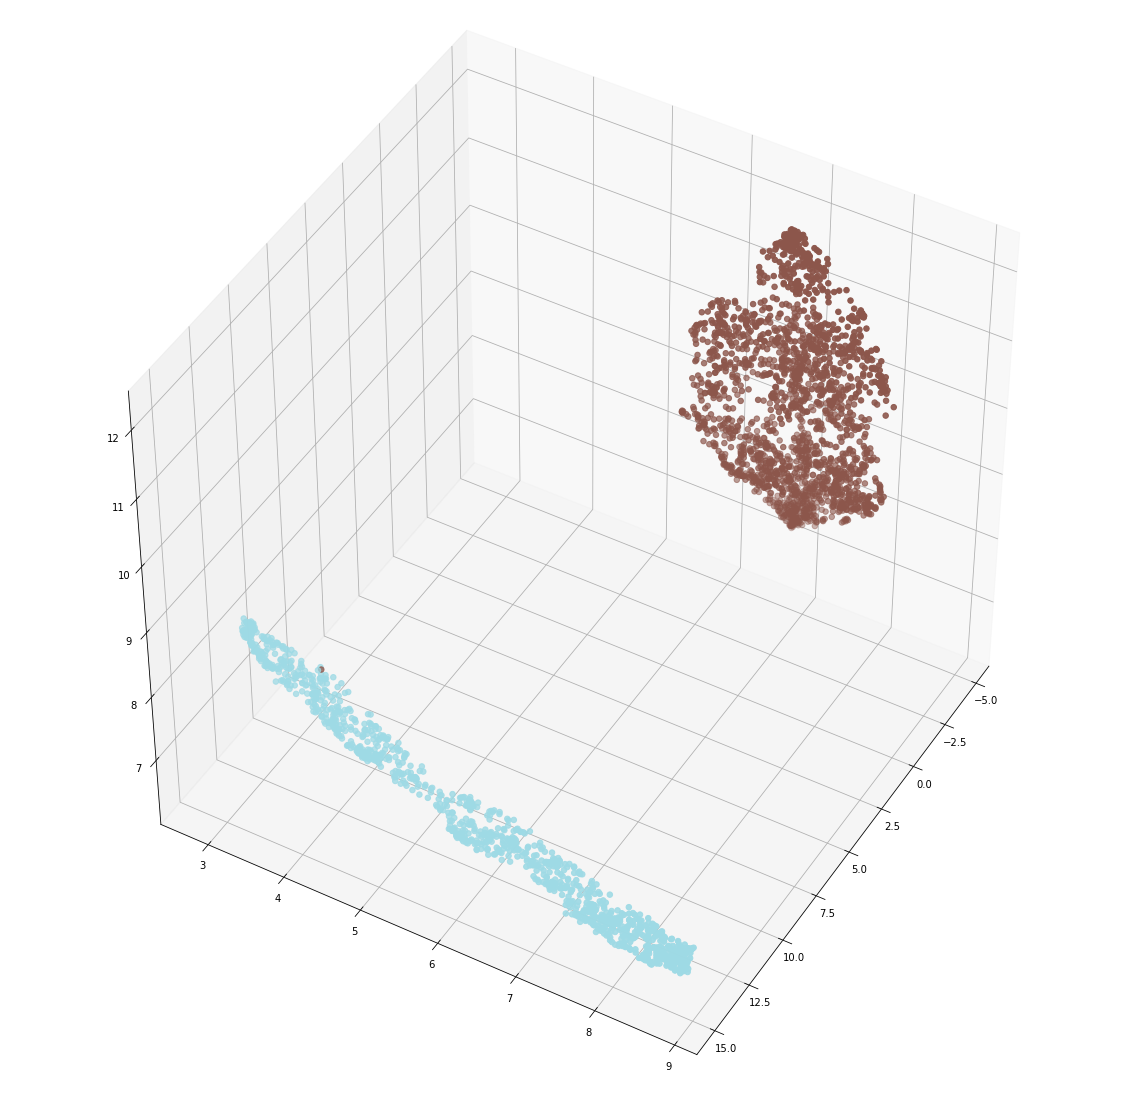

In [169]:
# 3 dimensional umap
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(filament_umap_3D[:,0], filament_umap_3D[:,1], filament_umap_3D[:,2], c=plt.cm.tab20((umap_predict+1)/filament_cluster_number), s=30)
ax.view_init(45,30)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_3D.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

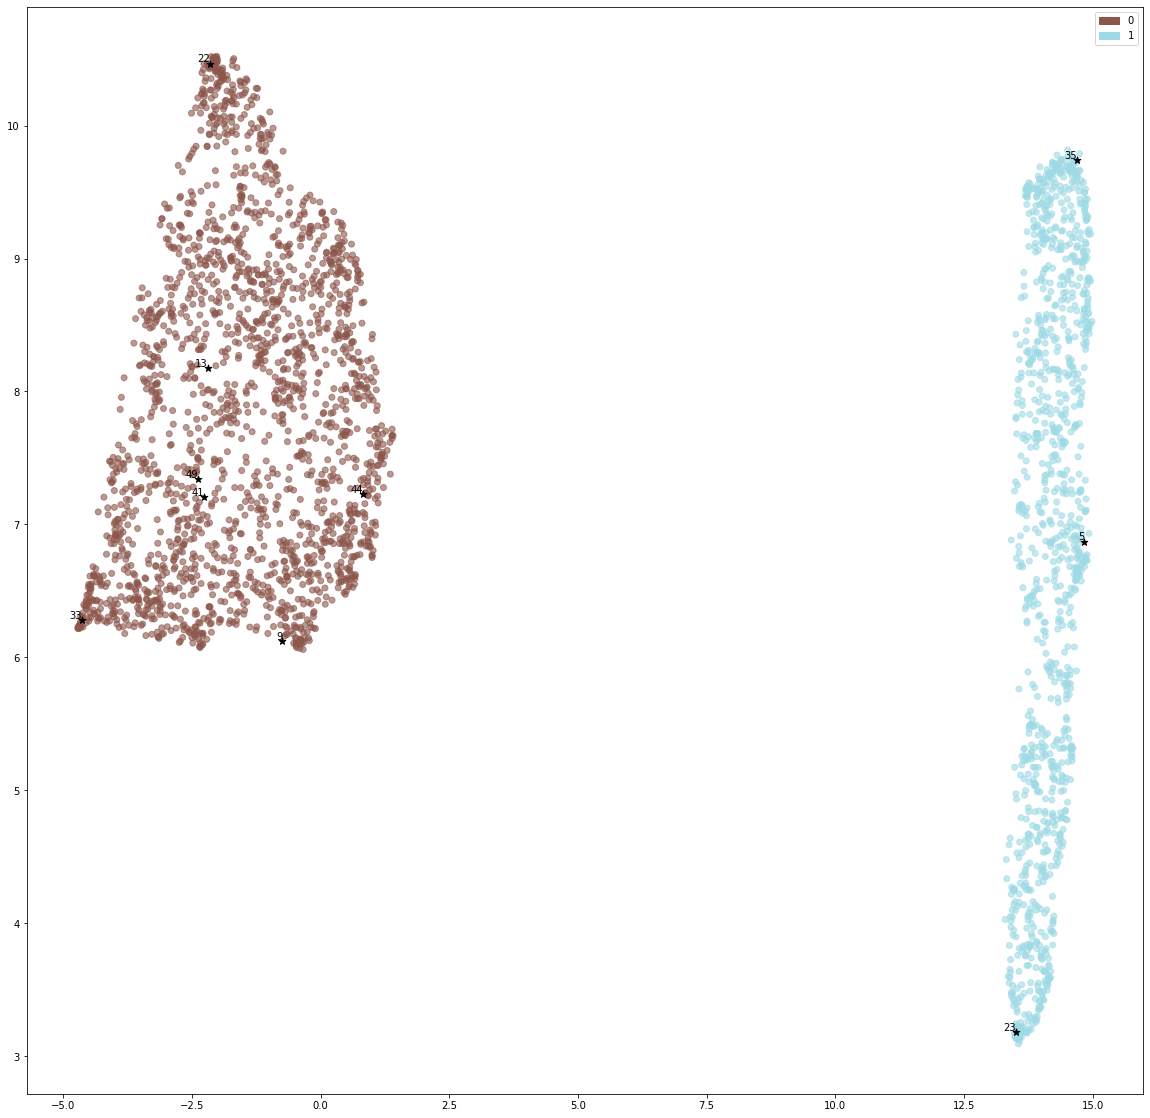

In [170]:
plt.figure(figsize = (20, 20))
for i in range(filament_cluster_number):
    locals()['labels'+str(i)]=mpatches.Patch(color=plt.cm.tab20((i+1)/filament_cluster_number), label=str(i))
plt.legend(handles=[eval('labels'+str(i)) for i in range(filament_cluster_number)])
plt.scatter(filament_umap[:,0], filament_umap[:,1],alpha=0.6,color=plt.cm.tab20((umap_predict+1)/filament_cluster_number))
for i in range(len(EMBEDDINGS_np)):
    plt.scatter(umap_2D[i+filament_number][0], umap_2D[i+filament_number][1],color='black',marker='*',s=50)
    plt.annotate(index_to_word[i], xy = (umap_2D[i+filament_number][0], umap_2D[i+filament_number][1]), ha='right',va='bottom')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_ignore.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
# color=plt.cm.RdYlBu((umap_predict[i]+1)/filament_cluster_number)

## Seperate the clusters

In [33]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    cluster_nameID='clusterID'+str(i)
    locals()[cluster_name]=[]
    locals()[cluster_nameID]=[]
data_line=0
cluster_choice=umap_predict
positive_label=[]
for i in range(len(cluster_choice)):
    lst=corpus[i]
    cluster_number=cluster_choice[i]
    cluster_name='cluster'+str(cluster_number)
    cluster_nameID='clusterID'+str(cluster_number)
    for j in range(len(lst)):
        locals()[cluster_name].append(data[data_line])
        locals()[cluster_nameID].append(data[data_line][7][18:21])
        data_line+=1
    positive_label.append(locals()[cluster_nameID][-1]) 

# Compare with the positive labels

[[0.0, 0.0], [0.0, 0.0]]
137885 82964 54921
a


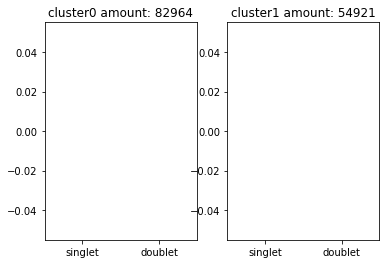

In [34]:
# histogram on rate of successful
#labels=['038','029'] #tau 10230
#labels_name=['PHF','SF']
labels=['124','126'] #tau 10340
labels_name=['singlet','doublet']
distribution_hist_all=[]
for i in range(filament_cluster_number):
    distribution_hist=[]
    lst=locals()['clusterID'+str(i)]
    for j in range(filament_cluster_number):
        group_percentage=lst.count(labels[j])/len(lst)
        distribution_hist.append(group_percentage)
    distribution_hist_all.append(distribution_hist)
print(distribution_hist_all)
print(len(data),len(cluster0),len(cluster1))

fig, ax = plt.subplots(1,filament_cluster_number)

for i in range(filament_cluster_number):
    ax[i].bar(range(filament_cluster_number),distribution_hist_all[i],tick_label =labels_name)
    particle_number=len(locals()['cluster'+str(i)])
    ax[i].set_title('cluster{} amount: {}'.format(i,particle_number))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+'distr_new.png')
print('a')

In [35]:
#label distribution
#from sklearn.manifold import TSNE, MDS,Isomap,SpectralEmbedding
#tsne =SpectralEmbedding(n_components=2,n_neighbors=10).fit_transform(all_data)
#filament_try=tsne[0:filament_number]

positive_label_new=np.array([float(labels.index(x)) for x in positive_label])
plt.figure(figsize = (20, 20))
for i in range(filament_cluster_number):
    locals()['true_label'+str(i)]=mpatches.Patch(color=plt.cm.tab20(i/(len(labels)+1)), label=labels_name[i])
plt.legend(handles=[eval('true_label'+str(i)) for i in range(len(labels))])
print(len(positive_label))
plt.scatter(filament_umap[:,0], filament_umap[:,1],color=plt.cm.tab20(positive_label_new/3))
for i in range(len(EMBEDDINGS_np)):
    plt.scatter(umap_2D[i+filament_number][0], umap_2D[i+filament_number][1],color='black',marker='*',s=50)
    plt.annotate(index_to_word[i], xy = (umap_2D[i+filament_number][0], umap_2D[i+filament_number][1]), ha='right',va='bottom')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_labels.png",bbox_inches='tight', pad_inches=0.01)
plt.show()

ValueError: '' is not in list

In [ ]:
#seperarte subcluster
for i in range(filament_cluster_number):
    cluster=locals()['cluster'+str(i)]
    lst=locals()['clusterID'+str(i)]
    for j in range(filament_cluster_number):
        subcluster_name='cluster'+str(i)+'_'+str(j)
        locals()[subcluster_name]=[x for x, y in zip(cluster,lst) if y==labels[j]]

# Write .star file for the clusters

In [ ]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    data_cluster=locals()[cluster_name]
    if datatype==0:
        output=process_relion.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.opticgroup(optics)
        output.writecluster()
    elif datatype==1:
        output=process_relion.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.writemetadata()
        output.writecluster()

In [ ]:
# write subcluster relion
for i in range(filament_cluster_number):
    for j in range(filament_cluster_number):
        cluster_name='cluster'+str(i)+'_'+str(j)
        data_cluster=locals()[cluster_name]
        if datatype==0:
            output=process_relion.output_star(output_path+'/'+file_name,str(i)+'_'+str(j),data_cluster,metadata)
            output.opticgroup(optics)
            output.writecluster()
        elif datatype==1:
            output=process_relion.output_star(output_path+'/'+file_name,str(i)+'_'+str(j),data_cluster,metadata)
            output.writemetadata()
            output.writecluster()

In [ ]:
with open('cluster_umap.npy', 'wb') as f:
    np.save(f, umap)